# Is this enough sarcasm? 
**A demonstration notebook**

**Group 20: Jeremy Dang, Joe Farrington and Ben Klasmer**


Key references:


*   https://github.com/NLPrinceton/SARC
*   http://nlp.cs.princeton.edu/SARC/
*   https://github.com/google-research/bert
*   https://github.com/huggingface/pytorch-pretrained-BERT
*   https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d [Trivedi, 2019]



## Setup - run all

### Imports

In [0]:
#Script to download publicly available Google Drive files
#From here https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    


if __name__ == "__main__":
    import sys
    if len(sys.argv) is not 3:
        print("Usage: python google_drive.py drive_file_id destination_file_path")
    else:
        # TAKE ID FROM SHAREABLE LINK
        file_id = sys.argv[1]
        # DESTINATION FILE ON YOUR DISK
        destination = sys.argv[2]
        download_file_from_google_drive(file_id, destination)

In [0]:
#Download the 100% model
download_file_from_google_drive('1-Yl4sIeOQFOVHwappEf7WJQ6O1KeUdIO', '/100_4.pickle')

In [0]:
#Download the 6.25% model
download_file_from_google_drive('1-IqSkj-P_TKv_WkvPM0EtrQXLmIvL2fd', '/6_4.pickle')

In [0]:
#Download the test set data
download_file_from_google_drive('1-Bdw9oqSdrNLOQWN9AaI5Qc5_eCLiP97', '/balanced_test.csv')

In [4]:
!pip install scikit-plot

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import f1_score
import scikitplot as skplt

In [6]:
!pip install pytorch-pretrained-bert
from pytorch_pretrained_bert.tokenization import BertTokenizer, WordpieceTokenizer
from pytorch_pretrained_bert.modeling import BertForPreTraining, BertModel, BertConfig, BertForMaskedLM, BertForSequenceClassification #PretrainedBertModel
from pathlib import Path
import torch
import re
from torch import Tensor
import collections
import os
import pdb
from tqdm import tqdm, trange
import sys
import random
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [0]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

### Declare classes and functions

In [0]:
### From pytorch-pretrained-bert
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [0]:
### From pytorch-pretrained-bert
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [0]:
### From pytorch-pretrained-bert
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_ids = label_map[example.label]

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=label_ids))
    return features

In [0]:
def softmax(A):
    """
    Calculates the value of softmax function
    
    Inputs:
    A -- N x 2 array of logits from BERT

    Output:
    probs -- N x 2 array of probabilities based on the softmax function
    """ 
    
    temp = np.exp(A)
    sumtemp = np.sum(temp, axis=1).reshape(-1,1)
    
    probs = temp/sumtemp
    
    return probs

In [0]:
def balanced_accuracy(out, labels):
  
  #'out' should be probabilities
  
  paired_pred = []

  for i in np.arange(0, len(out),2):
    if out[i][1] < out[i+1][1]:
      paired_pred.append(0)
      paired_pred.append(1)
    else:
      paired_pred.append(1)
      paired_pred.append(0)
  
  return np.sum(np.array(paired_pred) == labels)/len(out)

In [0]:
### From Trivedi, 2019
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [0]:
### Based on Trivedi, 2019
def eval(eval_examples, eval_features, model, device):
        
    args['output_dir'].mkdir(exist_ok=True)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in eval_features], dtype=torch.long)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args['eval_batch_size'])
    
    all_logits = None
    all_labels = None
    
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for input_ids, input_mask, segment_ids, label_ids in eval_dataloader:
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)

        with torch.no_grad():
            tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)

        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        if all_logits is None:
            all_logits = logits
        else:
            all_logits = np.concatenate((all_logits, logits), axis=0)
            
        if all_labels is None:
            all_labels = label_ids
        else:    
            all_labels = np.concatenate((all_labels, label_ids), axis=0)

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    
    result = {'loss': eval_loss,
              'accuracy': eval_accuracy}
    
    return (result, all_logits, all_labels)

### Set variables

In [0]:
OUTPUT_PATH = Path('/tmp/output')
OUTPUT_PATH.mkdir(parents=True, exist_ok = True)

In [0]:
### Set based on Trivedi, 2019
args = {
    "train_size": -1,
    "val_size": -1,
    "task_name": "sarcpol",
    "no_cuda": False,
    "bert_model": 'bert-base-uncased',
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 50,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 32 ,
    "eval_batch_size": 32,
    "learning_rate": 3e-5,
    "num_train_epochs": 5,
    "warmup_proportion": 0.1,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "loss_scale": 128
}

In [17]:
### From Trivedi, 2019
if args["local_rank"] == -1 or args["no_cuda"]:
    device = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")
    n_gpu = torch.cuda.device_count()
#     n_gpu = 1
else:
    torch.cuda.set_device(args['local_rank'])
    device = torch.device("cuda", args['local_rank'])
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args['local_rank'] != -1), args['fp16']))

03/16/2019 11:44:38 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False


### Load in and process the test set

In [0]:
#Load in the test sets
testdf_bal = pd.read_csv('/balanced_test.csv', index_col = 0)

In [0]:
#Process the balances test set examples
testbal_examples = []

for i in range(0,len(testdf_bal.index)):
        testbal_examples.append(InputExample(str(i), testdf_bal.loc[i,'response'], None, str(testdf_bal.loc[i,'label'])))

In [0]:
#Create a list of labels
label_list = ['0', '1']
num_labels = len(label_list)

In [21]:
#Instantiate the tokenizer
tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

03/16/2019 11:44:38 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpnqjmryxh
100%|██████████| 231508/231508 [00:00<00:00, 5537581.58B/s]
03/16/2019 11:44:38 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpnqjmryxh to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/16/2019 11:44:38 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/16/2019 11:44:38 - INFO - pytorch_pretrained_bert.file_utils -   removing temp file /tmp/tmpnqjmryxh
03/16/2019 11:44:38 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws

In [0]:
#Create the features based on the balanced test set
testbal_features = convert_examples_to_features(testbal_examples, label_list, args["max_seq_length"], tokenizer)

### Load in the models

In [0]:
with open("/100_4.pickle", 'rb') as handle:
  sbmodel_100 = pickle.load(handle)
  
with open("/6_4.pickle", 'rb') as handle:
  sbmodel_6 = pickle.load(handle)

## Evaluate the model fine-tuned with the 100% project training set

In [0]:
#Set evaluation batch size to 32
args["eval_batch_size"] = 32
#Get the predictions on the test set
result_100, logits_100, labels_100 = eval(testbal_examples, testbal_features, sbmodel_100, device)

In [25]:
#Print the results of the evaluation metrics
bal_acc_100 = balanced_accuracy(softmax(logits_100), labels_100)
F1_100 = f1_score(labels_100, np.argmax(logits_100, axis=1), labels=None, pos_label=1)
acc_100 = result_100['accuracy']
print('### BERT finetuned with 100% project training set: 10,933 examples ###')
print(f'Accuracy on the balanced task: {bal_acc_100:.3f}')
print(f'Accuracy without considering paired responses: {acc_100:.3f}')
print(f'F1 Score without considering paired responses: {F1_100:.3f}')

### BERT finetuned with 100% project training set: 10,933 examples###
Accuracy on the balanced task: 0.819
Accuracy without considering paired responses: 0.740
F1 Score without considering paired responses: 0.731


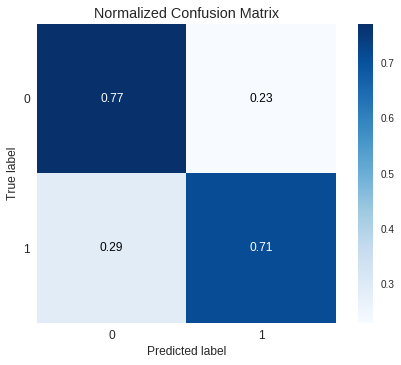

In [27]:
skplt.metrics.plot_confusion_matrix(labels_100, np.argmax(logits_100, axis=1), normalize=True);

## Evaluate the model fine-tuned with the 6.25% project training set

In [0]:
#Set evaluation batch size to 32
args["eval_batch_size"] = 32
#Get the predictions on the test set
result_6, logits_6, labels_6 = eval(testbal_examples, testbal_features, sbmodel_6, device)

In [31]:
#Print the results of the evaluation metrics
bal_acc_6 = balanced_accuracy(softmax(logits_6), labels_6)
F1_6 = f1_score(labels_6, np.argmax(logits_6, axis=1), labels=None, pos_label=1)
acc_6 = result_6['accuracy']
print('### BERT finetuned with 6.25% project training set: 681 examples ###')
print(f'Accuracy on the balanced task: {bal_acc_6:.3f}')
print(f'Accuracy without considering paired responses: {acc_6:.3f}')
print(f'F1 Score without considering paired responses: {F1_6:.3f}')

### BERT finetuned with 6.25% project training set: 681 examples ###
Accuracy on the balanced task: 0.711
Accuracy without considering paired responses: 0.658
F1 Score without considering paired responses: 0.650


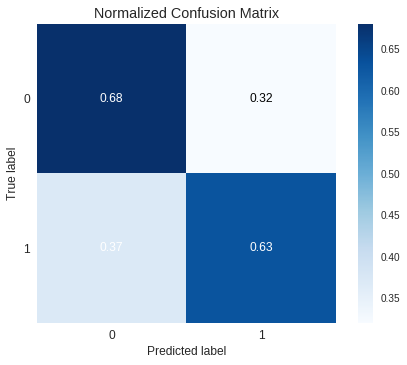

In [32]:
skplt.metrics.plot_confusion_matrix(labels_6, np.argmax(logits_6, axis=1), normalize=True);

## Test your own phrase

In [38]:
#@title Enter a comment to test { display-mode: "both" }

comment = "So you made a sarcasm detector? Big whoop!" #@param {type:"string"}

c_examples = [(InputExample(guid='i', text_a=comment, text_b=None, label='1'))]

#Tokenize the comment
c_features =  convert_examples_to_features(c_examples, label_list, args["max_seq_length"], tokenizer)

#Set evaluation batch size to 1
args["eval_batch_size"] = 1

_, logits_100, _ = eval(c_examples, c_features, sbmodel_100, device)

_, logits_6, _ = eval(c_examples, c_features, sbmodel_6, device)

#Print the result
if logits_100[0][1] > logits_100[0][0]:
  result_100 = 'being sarcastic'
else:
  result_100 = 'not being sarcastic'
  
if logits_6[0][1] > logits_6[0][0]:
  result_6 = 'being sarcastic'
else:
  result_6 = 'not being sarcastic'
  
  
print(f'BERT fine-tuned with the 100% project training set thinks you were {result_100}.')
print(f'BERT fine-tuned with the 6.25% project training set thinks you were {result_6}.')

BERT trained on the 100% project training set thinks you were being sarcastic.
BERT trained on the 6.25% project training set thinks you were being sarcastic.
